## CNN classifier for multi label tagging of Myntra fashion products

In [1]:
# Execute only in colab
import tensorflow as tf
if tf.__version__ > "1.15.0":
  !pip uninstall tensorflow
  !pip install tensorflow==1.15.0

print('tensorflow version: ', tf.__version__)

tensorflow version:  1.15.0


In [2]:
import numpy as np
import pandas as pd
import os
import PIL
import sys
import time
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import SGD

from keras.preprocessing.image import load_img, img_to_array

from google.colab import files


Using TensorFlow backend.


##### If you are working on your local computer. Download and extract the dataset from https://www.kaggle.com/paramaggarwal/fashion-product-images-small
##### As the productDisplayName column in styles.csv needed modification. Extract only the images folder into your CNN_model_fashion_products_multi_label_tagging/images/ directory. Make use of styles.csv from this repository.

In [0]:
folder_path = os.getcwd()
# folder_path = os.path.join(folder_path, 'CNN_model_fashion_products_multi_label_tagging')

### Run below cell only in google colab
##### Upload your kaggle.json file into colab before you run below cell.
##### Download the kaggle.json file from your kaggle Profile/Account/API by clicking "Create New API Token".

In [5]:
!git clone https://github.com/sharathrjtr/CNN_model_fashion_products_multi_label_tagging.git
folder_path = os.path.join(folder_path, 'CNN_model_fashion_products_multi_label_tagging')

# Download the Kaggle Myntra fashion products small dataset
# For details: https://github.com/Kaggle/kaggle-api

# Two methods to authenticate your kaggle account. 

# Method 1: Fill in the details of username and key below from the kaggle.json.
# os.environ['KAGGLE_USERNAME'] = "username"
# os.environ['KAGGLE_KEY'] = "xxxxxxxxxxxxxx"

# Method 2: If kaggle.json is already uploaded in colab directory /content/
os.environ['KAGGLE_CONFIG_DIR']='/content/'

!kaggle datasets download -d paramaggarwal/fashion-product-images-small

# Unzip the download dataset into the CNN model directory excluding the styles.csv and directory myntradataset/
!unzip fashion-product-images-small.zip -x styles.csv myntradataset/* -d CNN_model_fashion_products_multi_label_tagging/myntradataset/

Streaming output truncated to the last 5000 lines.
  inflating: CNN_model_fashion_products_multi_label_tagging/myntradataset/images/58129.jpg  
  inflating: CNN_model_fashion_products_multi_label_tagging/myntradataset/images/5813.jpg  
  inflating: CNN_model_fashion_products_multi_label_tagging/myntradataset/images/58131.jpg  
  inflating: CNN_model_fashion_products_multi_label_tagging/myntradataset/images/58132.jpg  
  inflating: CNN_model_fashion_products_multi_label_tagging/myntradataset/images/58133.jpg  
  inflating: CNN_model_fashion_products_multi_label_tagging/myntradataset/images/58135.jpg  
  inflating: CNN_model_fashion_products_multi_label_tagging/myntradataset/images/58136.jpg  
  inflating: CNN_model_fashion_products_multi_label_tagging/myntradataset/images/58137.jpg  
  inflating: CNN_model_fashion_products_multi_label_tagging/myntradataset/images/58138.jpg  
  inflating: CNN_model_fashion_products_multi_label_tagging/myntradataset/images/58139.jpg  
  inflating: CNN_mod

In [0]:
def cleanup_csv_mapping(mapping_csv):
    # articleType can be used to find subCategory and masterCategory. 
    # Year specifies particular year the product is made, productDisplayName is something unique to the product and not a generalization.
    # Hence, we are dropping masterCategory, subCartegory, year and productDisplayName columns from the data frame.
    print('Dropping columns: [masterCategory, subCategory, year, productDisplayName]')
    mapping_csv.drop(['masterCategory', 'subCategory', 'year', 'productDisplayName'], axis=1, inplace=True)

    # Drop the samples which don't have any value in any of the columns.
    print('Dropping rows with no value in any of columns')
    mapping_csv.dropna(inplace=True)
    mapping_csv.head()

    for idx, row in mapping_csv.iterrows():
      if not os.path.exists(folder_path+'/myntradataset/images/'+str(row['id'])+'.jpg'):
        mapping_csv.drop(axis=0, index=idx, inplace=True)
        # print('Removed inexisting file: ', str(row['id'])+'.jpg, article: ',row['articleType'])
    
    return mapping_csv

In [0]:
def cleanup_csv_articletype(mapping_csv, article_type):
  for idx, row in mapping_csv.iterrows():
    if row['articleType'] in article_type:
      mapping_csv.drop(axis=0, index=idx, inplace=True)
      print('Removed articleType: %s, File: %d' %(row['articleType'], row['id']))

In [60]:
def countCategory(gender='Men', article='Tshirts', color='White', usage='Casual'):
  count = 0
  for idx, row in mapping_csv.iterrows():
    if row['gender']==gender and row['articleType']==article and row['baseColour']==color and row['usage']==usage:
      count += 1
  return count
      

ERROR! Session/line number was not unique in database. History logging moved to new session 64


In [0]:
# create a list of tags available among gender, articleType, baseColour, season and usage
# generate a mapping from tags to integers and integers to tags
def extract_tags_mapping(mapping_csv):
    labels_all = set()
    labels_gender = set()
    labels_article_type = set()
    labels_base_colour = set()
    labels_season = set()
    labels_usage = set()

    for index, row in mapping_csv.iterrows():
        gender = row['gender']
        article_type = row['articleType']
        base_colour = row['baseColour']
        season = row['season']
        usage = row['usage']
        
        if os.path.exists(folder_path+'/myntradataset/images/'+str(row['id'])+'.jpg'):
          labels_all.update([gender, article_type, base_colour, season, usage])
          labels_gender.update([gender])
          labels_article_type.update([article_type])
          labels_base_colour.update([base_colour])
          labels_season.update([season])
          labels_usage.update([usage])

    # convert the labels to a list and sort them alphabetically
    labels_all = list(labels_all)
    # order set alphabetically
    labels_all.sort()

    labels_gender = list(labels_gender)
    labels_gender.sort()

    labels_article_type = list(labels_article_type)
    labels_article_type.sort()
    
    labels_base_colour = list(labels_base_colour)
    labels_base_colour.sort()
    
    labels_season = list(labels_season)
    labels_season.sort()
    
    labels_usage = list(labels_usage)
    labels_usage.sort()
    
    return labels_all, labels_gender, labels_article_type, labels_base_colour, labels_season, labels_usage
    
    # return labels_map, inv_labels_map,
    # return gender_map, inv_gender_map, articletype_map, inv_articletype_map, color_map, inv_color_map, season_map, inv_season_map, usage_map, inv_usage_map

In [0]:
# create mapping from label to indices and indices to labels
def label_idx_mapping(labels_all, labels_gender, labels_article_type, labels_base_colour, labels_season, labels_usage):
    # create dictionary that maps labels to integers so that we can encode the training dataset for modeling.
    # create a dictionary with reverse mapping from integers to string tag values, so later when the model makes a prediction, we can turn it into something readable.
    alllabels_map = {labels_all[i]: i for i in range(len(labels_all))}
    inv_alllabels_map = {i:labels_all[i] for i in range(len(labels_all))}

    gender_map = {labels_gender[i]: i for i in range(len(labels_gender))}
    inv_gender_map = {i:labels_gender[i] for i in range(len(labels_gender))}

    articletype_map = {labels_article_type[i]: i for i in range(len(labels_article_type))}
    inv_articletype_map = {i:labels_article_type[i] for i in range(len(labels_article_type))}
    
    colour_map = {labels_base_colour[i]: i for i in range(len(labels_base_colour))}
    inv_colour_map = {i:labels_base_colour[i] for i in range(len(labels_base_colour))}
    
    season_map = {labels_season[i]: i for i in range(len(labels_season))}
    inv_season_map = {i:labels_season[i] for i in range(len(labels_season))}
    
    usage_map = {labels_usage[i]: i for i in range(len(labels_usage))}
    inv_usage_map = {i:labels_usage[i] for i in range(len(labels_usage))}

    return alllabels_map, inv_alllabels_map, gender_map, inv_gender_map, articletype_map, inv_articletype_map, colour_map, inv_colour_map, season_map, inv_season_map, usage_map, inv_usage_map

In [0]:
# get the list of fileid's for each of article_type
def article_fileid(mapping_csv, labels_article_type):
  article_fileid = {k: [] for k in labels_article_type}
  for index, row in mapping_csv.iterrows():
    article_fileid[row['articleType']].append(row['id'])
  
  return article_fileid

In [0]:
# obtain distribution of samples over the all labels
def distribution_samples_labels(mapping_csv, labels_gender, labels_article_type, labels_base_colour, labels_season, labels_usage):
    num_samples_gender = [0]*len(labels_gender)
    num_samples_article_type = [0]*len(labels_article_type)
    num_samples_base_colour = [0]*len(labels_base_colour)
    num_samples_season = [0]*len(labels_season)
    num_samples_usage = [0]*len(labels_usage)

    for index, row in mapping_csv.iterrows():
        gender = row['gender']
        article_type = row['articleType']
        base_colour = row['baseColour']
        season = row['season']
        usage = row['usage']

        num_samples_gender[labels_gender[gender]] += 1
        num_samples_article_type[labels_article_type[article_type]] += 1
        num_samples_base_colour[labels_base_colour[base_colour]] += 1
        num_samples_season[labels_season[season]] += 1
        num_samples_usage[labels_usage[usage]] += 1

    return num_samples_gender, num_samples_article_type, num_samples_base_colour, num_samples_season, num_samples_usage

In [0]:
# extract the training images filename and labels for all images.
def extract_img_ids_labels(mapping_csv):
    image_ids = []
    image_labels = dict()
    num_sample_per_label = np.zeros(len(image_labels), dtype='int16')
    for index, row in mapping_csv.iterrows():
        fileid = row['id']
        gender = row['gender']
        article_type = row['articleType']
        base_colour = row['baseColour']
        season = row['season']
        usage = row['usage']
        
        # if os.path.exists(folder_path+'/myntradataset/images/'+str(fileid)+'.jpg'):
        image_ids.append(fileid)
        image_labels[fileid] = [gender, article_type, base_colour, season, usage]
    
    return image_ids, image_labels

In [0]:
# create a one hot encoding for one list of tags
def one_hot_encode(tags, mapping):
    # create empty vector
    encoding = np.zeros(len(mapping), dtype='uint8')
    # mark 1 for each tag in the vector
    for tag in tags:
        encoding[mapping[tag]] = 1
    return encoding

In [0]:
# load the image and target
def load_image_target(filename, image_labels, tag_mapping):
  # load image
  image = load_img(os.path.join(folder_path+'/myntradataset/images', str(filename)+'.jpg'), target_size=(60,80))
  # convert to numpy array
  image = img_to_array(image, dtype='uint8')
  # get tags
  tags = image_labels[filename]
  # one hot encode tags
  target = one_hot_encode(tags, tag_mapping)
  
  return image, target

In [0]:
# load images and extract labels in one hot encode form
def load_dataset(image_ids, image_labels, tag_mapping):
    images, targets = list(), list()
    # enumerate file in the directory
    for filename in image_ids:
        image, target = load_image_target(filename, image_labels, tag_mapping)
        
        # store train image and tags
        images.append(image)
        targets.append(target)
    
    X = np.asarray(images, dtype='uint8')
    y = np.asarray(targets, dtype='uint8')
    return X, y

In [0]:
# load synthetic images and targets for article type which has less in number of images in dataset than threshold limit specified
def add_synthetic_data_article(article_fileids, X, y, image_labels, tag_mapping, threshold_num=50):
  i=0
  for article, file_ids in article_fileids.items():
    p = len(article_fileids)-i
    print('Items pending: ', p)
    i += 1

    if len(file_ids) < threshold_num:
      print(article, ": ", len(file_ids))
      nimgs, ntrgts = list(), list()
      for filename in file_ids:
        image, target = load_image_target(filename, image_labels, tag_mapping)
        nimgs.append(image)
        ntrgts.append(target)
            
      nimages = np.asarray(nimgs, dtype='uint8')
      ntargets = np.asarray(ntrgts, dtype='uint8')
      datagen = ImageDataGenerator(rotation_range=90, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.1, zoom_range=0.1, horizontal_flip=True)
      it = datagen.flow(nimages, ntargets, batch_size=len(file_ids))
      pending_nfiles = threshold_num - len(file_ids)
      for _ in range(int(np.ceil(float(pending_nfiles)/len(file_ids)))):
        X_new, y_new = next(it)
        # print('Additional generated image files shape: ', X_new.shape)
        # print('Additional generated labels shape: ', y_new.shape)

        X = np.concatenate((X, X_new), axis=0)
        y = np.concatenate((y, y_new), axis=0)
      
      fig, ax = pyplot.subplots(nrows=2, ncols = 5, figsize=(15,10))
      fig.tight_layout()
      for i in range(2):
          for j in range(5):
              ax[i,j].imshow(X[-1 - i*5 - j, :, :, :])
              ax[i,j].axis('off')
              if j==2 and i==0:
                  ax[i,j].set_title(article)

      print('New Dataset shape - Images: ', X.shape, ' Labels: ', y.shape)

      break

  return X, y

In [31]:
csv_filename = folder_path+'/myntradataset/styles.csv'
# Read the csv file and clean up the file to extract relevant data
# productDisplayName column consist of extra commas for few row. 
# These were manually removed as it can result in error during reading of the file
mapping_csv = pd.read_csv(csv_filename)
print('Dataset Mapping dataframe size before cleanup: ', mapping_csv.shape)

mapping_csv = cleanup_csv_mapping(mapping_csv)
print('Dataset Mapping dataframe size after cleanup: ', mapping_csv.shape)
mapping_csv.head()

Dataset Mapping dataframe size before cleanup:  (44446, 10)
Dropping columns: [masterCategory, subCategory, year, productDisplayName]
Dropping rows with no value in any of columns
Removed inexisting file:  39403.jpg, article:  Shirts
Removed inexisting file:  39410.jpg, article:  Shirts
Removed inexisting file:  39401.jpg, article:  Jeans
Removed inexisting file:  39425.jpg, article:  Tshirts
Removed inexisting file:  12347.jpg, article:  Suits
Dataset Mapping dataframe size after cleanup:  (44096, 6)


,id,gender,articleType,baseColour,season,usage
0,15970,Men,Shirts,Navy Blue,Fall,Casual
1,39386,Men,Jeans,Blue,Summer,Casual
2,59263,Women,Watches,Silver,Winter,Casual
3,21379,Men,Track Pants,Black,Fall,Casual
4,53759,Men,Tshirts,Grey,Summer,Casual


In [32]:
# extract set of gender labels, article type labels, color labels, season labels, usage labels and a set of all these labels
labels_all, labels_gender, labels_article, labels_color, labels_season, labels_usage = extract_tags_mapping(mapping_csv)
print('Number of Labels - all: %d, Gender: %d, Article: %d, Color: %d, Season: %d, Usage: %d' %(len(labels_all), len(labels_gender), len(labels_article), len(labels_color), len(labels_season), len(labels_usage)))

# extract mapping from labels to indices and indices to labels for all labels and individual category labels
alllabels_idx, idx_alllabels, gender_idx, idx_gender, article_idx, idx_article, color_idx, idx_color, season_idx, idx_season, usage_idx, idx_usage = label_idx_mapping(labels_all, labels_gender, labels_article, labels_color, labels_season, labels_usage)

Number of Labels - all: 204, Gender: 5, Article: 141, Color: 46, Season: 4, Usage: 8
Number of train files:  44096


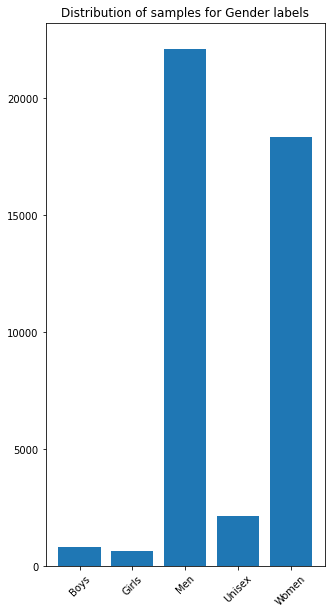

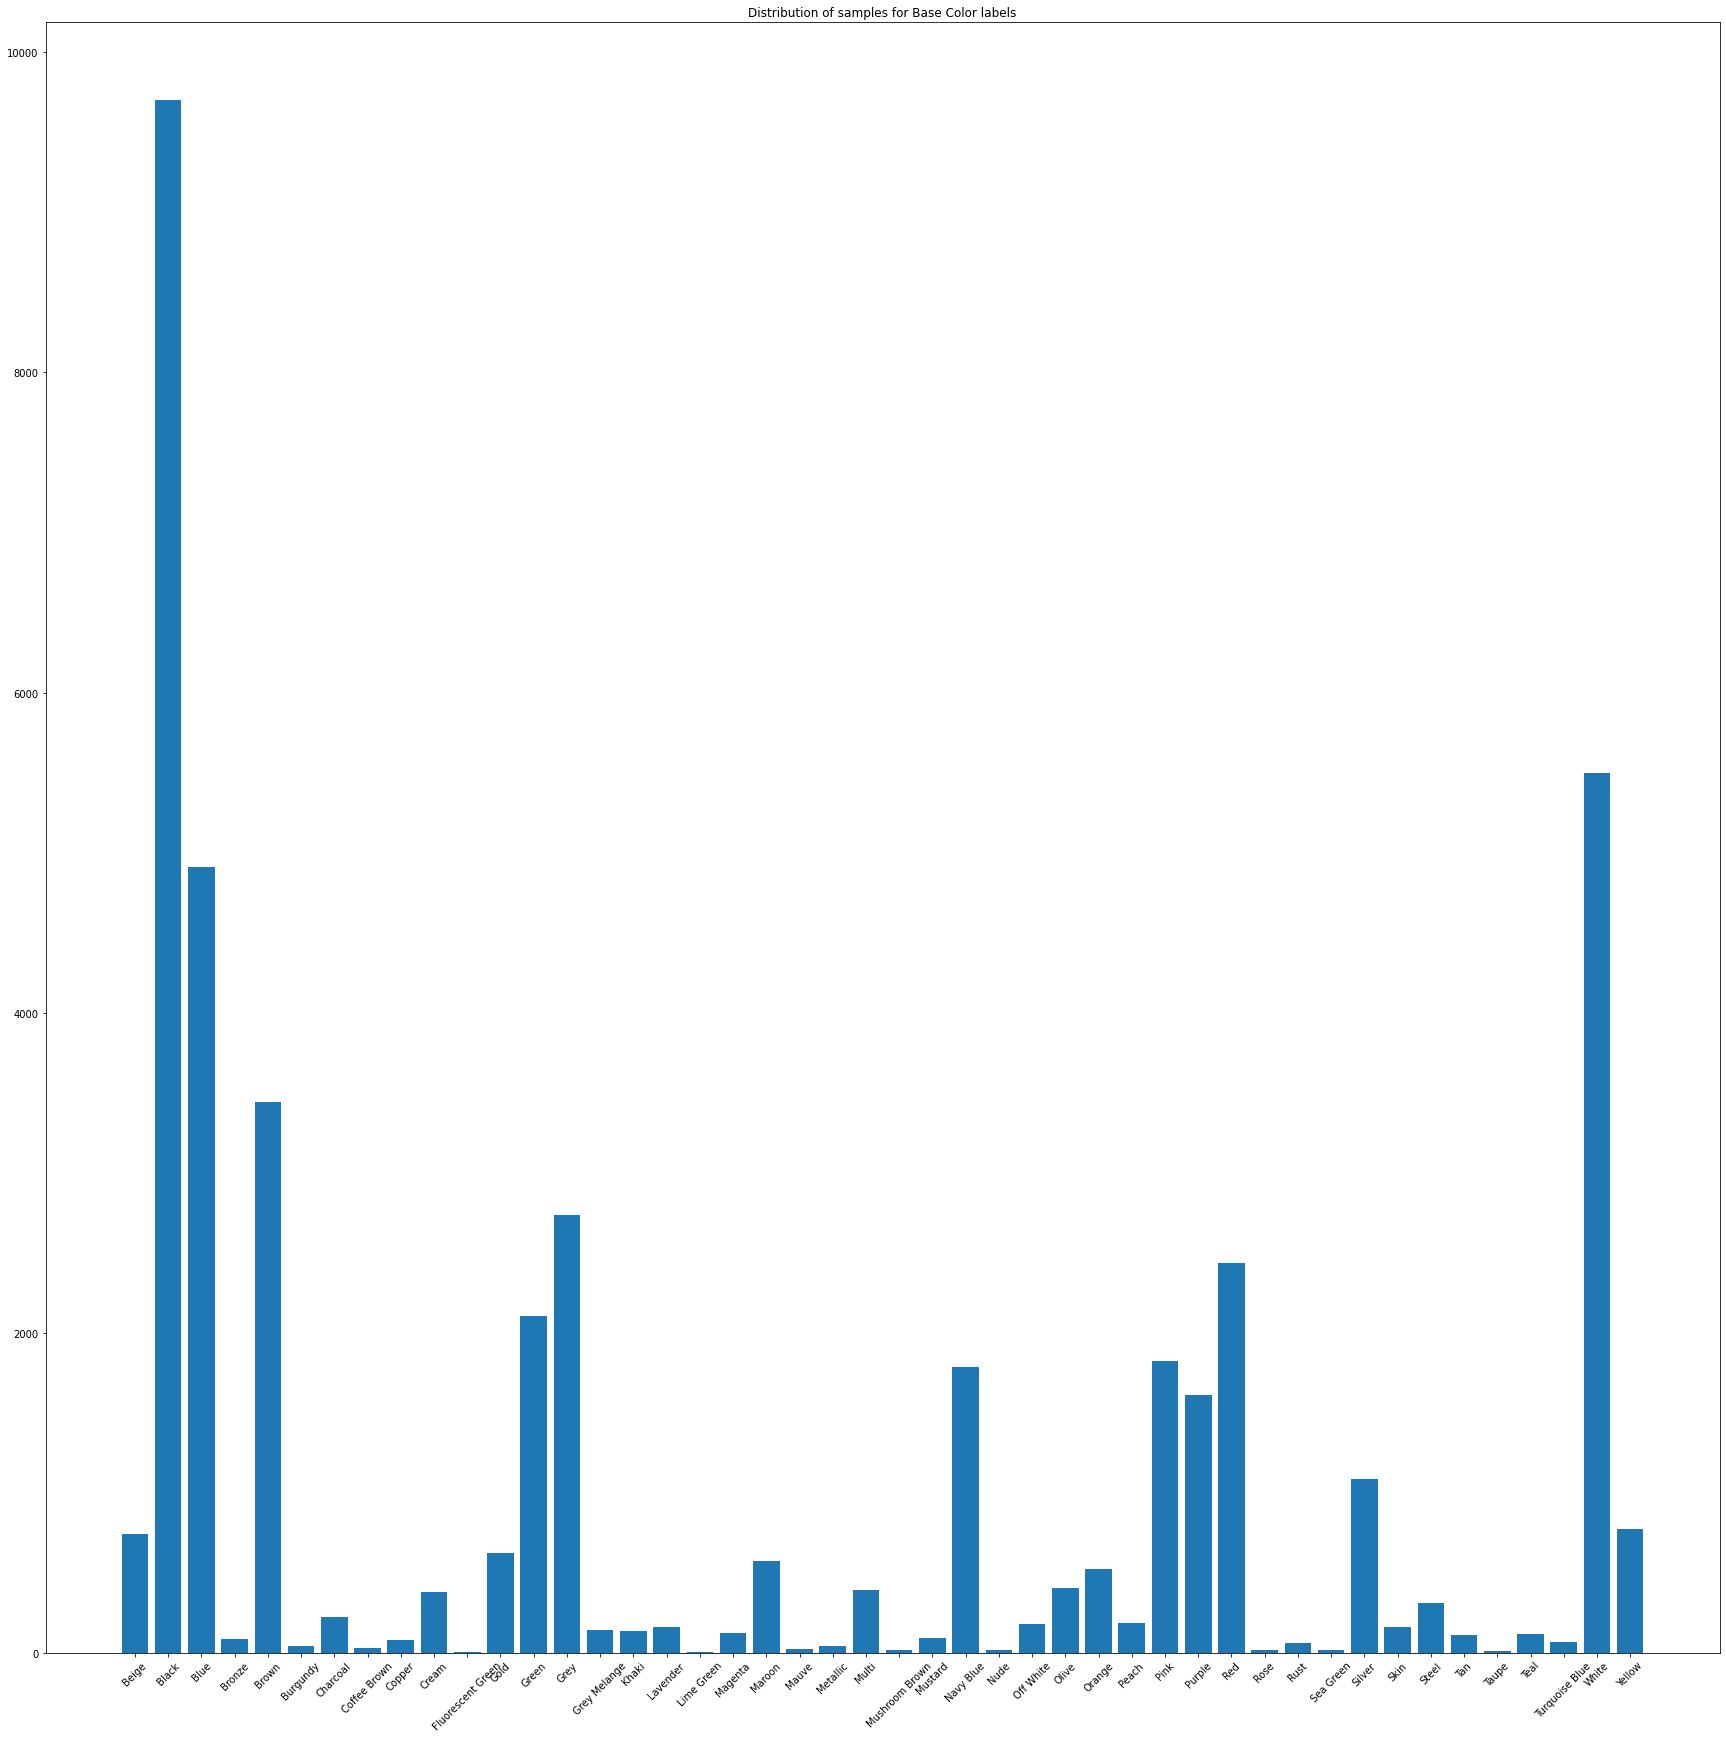

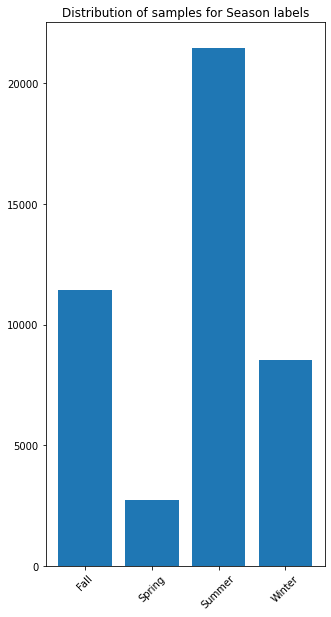

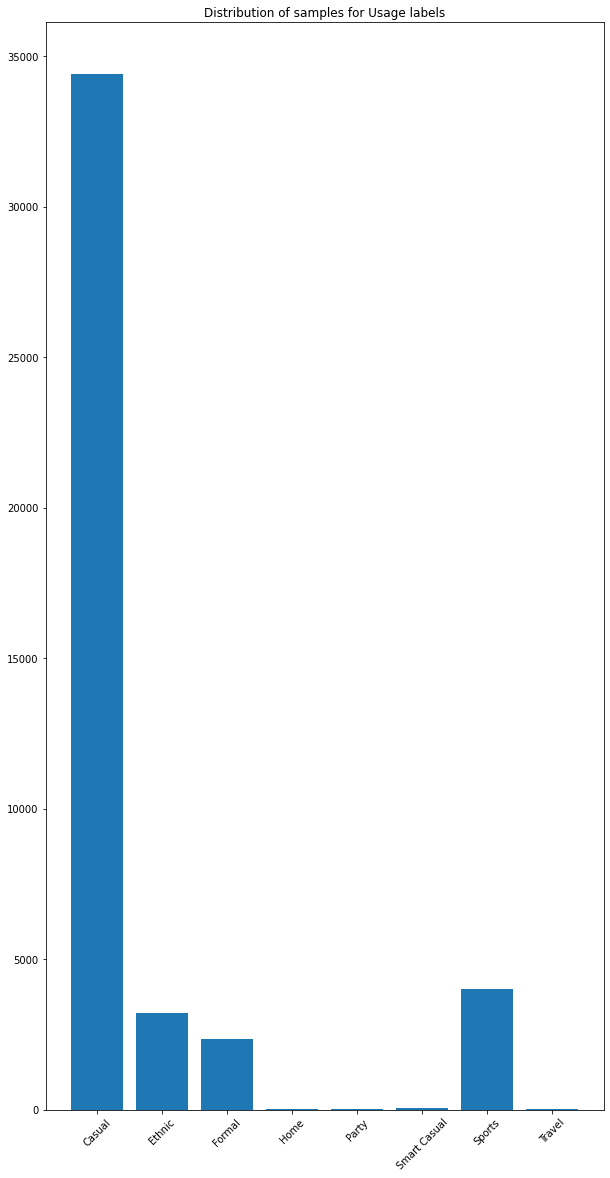

In [38]:
# plot distribution of samples over dataset available
num_samples_gender, num_samples_article, num_samples_base_color, num_samples_season, num_samples_usage = distribution_samples_labels(mapping_csv, gender_idx, article_idx, color_idx, season_idx, usage_idx)

# print('\nsample dist for gender: ', len(num_samples_gender))
# for i in range(len(num_samples_gender)):
#     print(idx_gender[i], ': ', num_samples_gender[i])
pyplot.figure(figsize=(5,10))
pyplot.bar(gender_idx.keys(), num_samples_gender)
pyplot.title('Distribution of samples for Gender labels')
t = pyplot.xticks(rotation=45)

# print('\nsample dist for article type: ', len(num_samples_article))
# for i in range(len(num_samples_article)):
#     print(idx_article[i], ': ', num_samples_article[i])
pyplot.figure(figsize=(200,80))
pyplot.bar(article_idx.keys(), num_samples_article)
pyplot.title('Distribution of samples for Article Type labels')
t = pyplot.xticks(rotation=45)

# print('\nsample dist for base color: ', len(num_samples_base_color))
# for i in range(len(num_samples_base_color)):
#     print(idx_color[i], ': ', num_samples_base_color[i])
pyplot.figure(figsize=(30,30))
pyplot.bar(color_idx.keys(), num_samples_base_color)
pyplot.title('Distribution of samples for Base Color labels')
t = pyplot.xticks(rotation=45)

# print('\nsample dist for season: ', len(num_samples_season))
# for i in range(len(num_samples_season)):
#     print(idx_season[i], ': ', num_samples_season[i])
pyplot.figure(figsize=(5,10))
pyplot.bar(season_idx.keys(), num_samples_season)
pyplot.title('Distribution of samples for Season labels')
t = pyplot.xticks(rotation=45)

# print('\nsample dist for usage: ', len(num_samples_usage))
# for i in range(len(num_samples_usage)):
#     print(idx_usage[i], ': ', num_samples_usage[i])
pyplot.figure(figsize=(10,20))
pyplot.bar(usage_idx.keys(), num_samples_usage)
pyplot.title('Distribution of samples for Usage labels')
t = pyplot.xticks(rotation=45)



In [55]:
# We need to have at least 10 samples per articleType labels so that we can have reliable training with synthetic samples generated
# Remove the rows from csv file having less than 10 samples per article type.

# Create list of all the article type labels that have less than 10 samples.
remove_article=[]
for i, v in enumerate(num_samples_article):
  if v<10:
    print(idx_article[i], "has samples: \t%d" %(v))
    remove_article.append(idx_article[i])

print(remove_article)
print('\nTotal number of articleType to remove: ', len(remove_article))

cleanup_csv_articletype(mapping_csv, remove_article)

Beauty Accessory has samples: 	3
Blazers has samples: 	8
Body Lotion has samples: 	3
Body Wash and Scrub has samples: 	1
Clothing Set has samples: 	8
Cushion Covers has samples: 	1
Eye Cream has samples: 	4
Face Scrub and Exfoliator has samples: 	4
Face Serum and Gel has samples: 	2
Footballs has samples: 	8
Hair Accessory has samples: 	1
Hat has samples: 	3
Headband has samples: 	7
Ipad has samples: 	1
Key chain has samples: 	2
Lehenga Choli has samples: 	4
Lip Care has samples: 	7
Lip Plumper has samples: 	4
Lounge Tshirts has samples: 	3
Makeup Remover has samples: 	2
Mens Grooming Kit has samples: 	1
Nail Essentials has samples: 	6
Nehru Jackets has samples: 	5
Rain Jacket has samples: 	7
Robe has samples: 	4
Salwar and Dupatta has samples: 	7
Shapewear has samples: 	9
Shoe Accessories has samples: 	3
Shoe Laces has samples: 	1
Shrug has samples: 	6
Tablet Sleeve has samples: 	3
Ties and Cufflinks has samples: 	2
Tights has samples: 	9
Toner has samples: 	2
Trolley Bag has samples:

In [57]:
# extract set of gender labels, article type labels, color labels, season labels, usage labels and a set of all these labels
labels_all, labels_gender, labels_article, labels_color, labels_season, labels_usage = extract_tags_mapping(mapping_csv)
print('Number of Labels - all: %d, Gender: %d, Article: %d, Color: %d, Season: %d, Usage: %d' %(len(labels_all), len(labels_gender), len(labels_article), len(labels_color), len(labels_season), len(labels_usage)))

# extract mapping from labels to indices and indices to labels for all labels and individual category labels
alllabels_idx, idx_alllabels, gender_idx, idx_gender, article_idx, idx_article, color_idx, idx_color, season_idx, idx_season, usage_idx, idx_usage = label_idx_mapping(labels_all, labels_gender, labels_article, labels_color, labels_season, labels_usage)


Number of Labels - all: 166, Gender: 5, Article: 104, Color: 46, Season: 4, Usage: 7



sample dist for gender:  5
Boys :  824
Girls :  650
Men :  22103
Unisex :  2091
Women :  18271

sample dist for article type:  104
Accessory Gift Set :  111
Baby Dolls :  14
Backpacks :  724
Bangle :  85
Basketballs :  13
Bath Robe :  17
Belts :  813
Booties :  12
Boxers :  52
Bra :  477
Bracelet :  66
Briefs :  847
Camisoles :  39
Capris :  175
Caps :  283
Casual Shoes :  2846
Churidar :  30
Clutches :  290
Compact :  39
Concealer :  11
Cufflinks :  106
Deodorant :  347
Dresses :  464
Duffel Bag :  88
Dupatta :  116
Earrings :  417
Eyeshadow :  32
Face Moisturisers :  47
Face Wash and Cleanser :  16
Flats :  500
Flip Flops :  916
Formal Shoes :  637
Foundation and Primer :  69
Fragrance Gift Set :  57
Free Gifts :  91
Gloves :  20
Hair Colour :  19
Handbags :  1759
Heels :  1323
Highlighter and Blush :  38
Innerwear Vests :  242
Jackets :  258
Jeans :  602
Jeggings :  34
Jewellery Set :  58
Jumpsuit :  16
Kajal and Eyeliner :  94
Kurta Sets :  94
Kurtas :  1844
Kurtis :  234
Laptop B

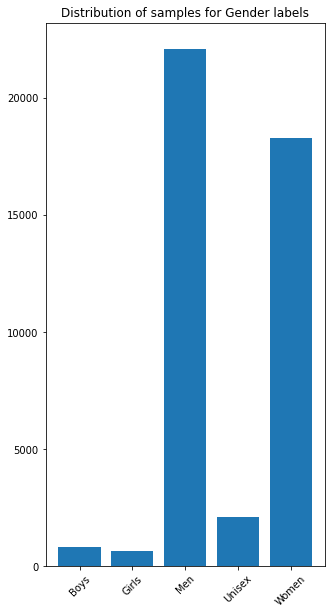

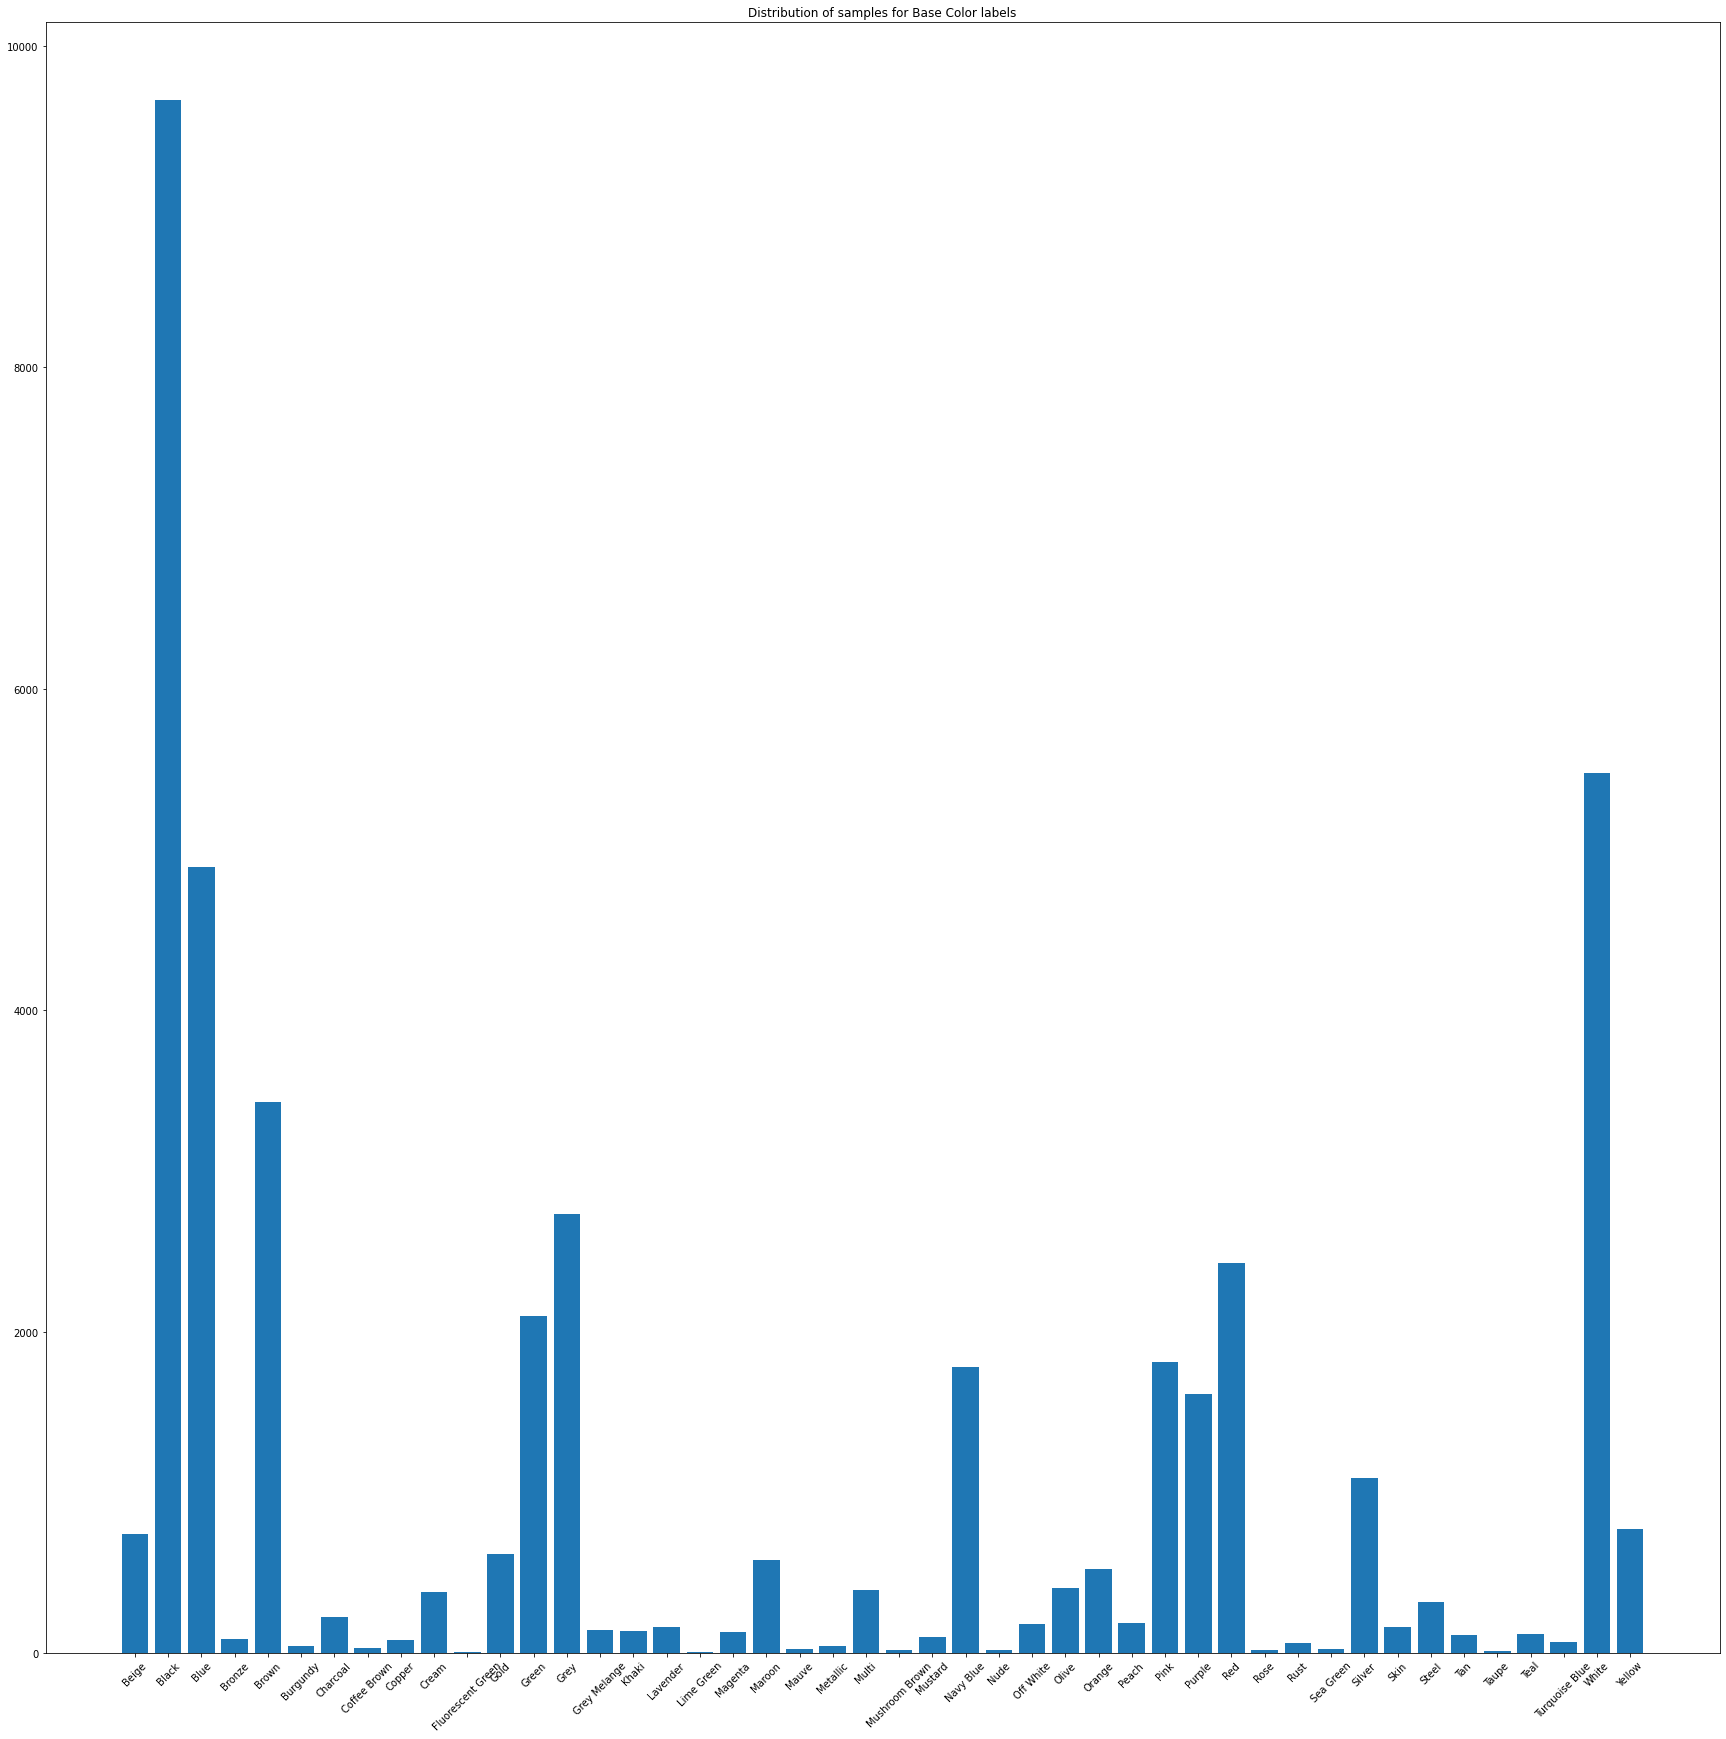

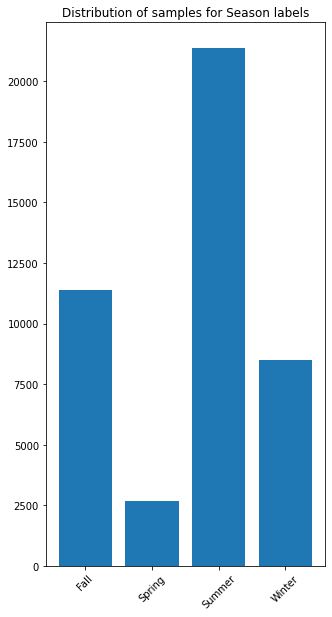

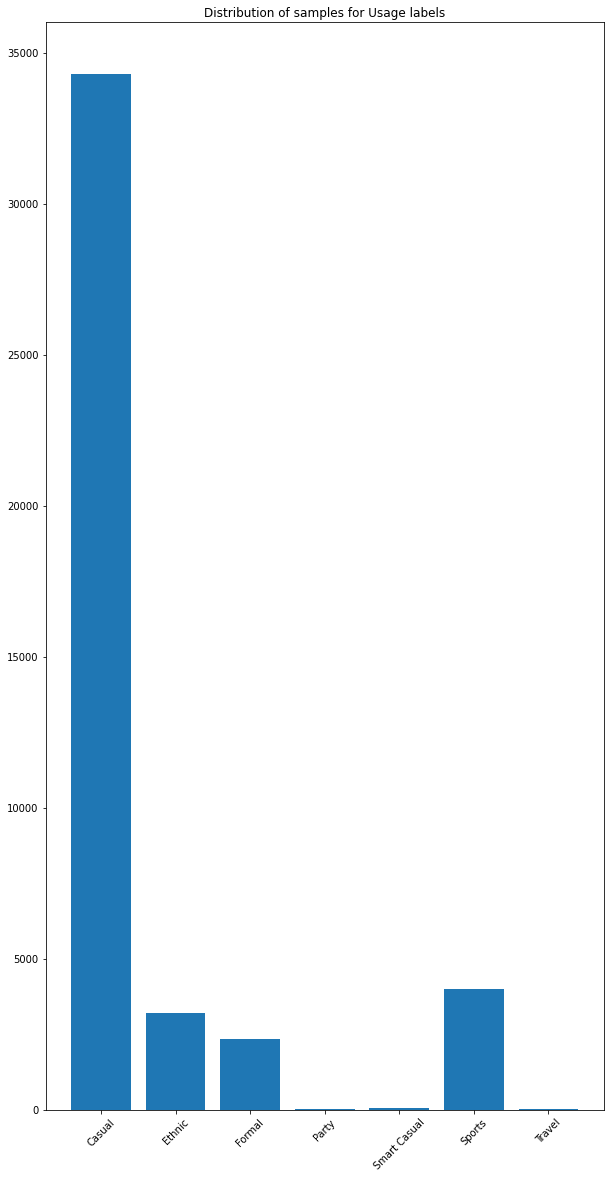

In [59]:
# plot distribution of samples over dataset available
num_samples_gender, num_samples_article, num_samples_base_color, num_samples_season, num_samples_usage = distribution_samples_labels(mapping_csv, gender_idx, article_idx, color_idx, season_idx, usage_idx)

print('\nsample dist for gender: ', len(num_samples_gender))
for i in range(len(num_samples_gender)):
    print(idx_gender[i], ': ', num_samples_gender[i])
pyplot.figure(figsize=(5,10))
pyplot.bar(gender_idx.keys(), num_samples_gender)
pyplot.title('Distribution of samples for Gender labels')
t = pyplot.xticks(rotation=45)

print('\nsample dist for article type: ', len(num_samples_article))
for i in range(len(num_samples_article)):
    print(idx_article[i], ': ', num_samples_article[i])
pyplot.figure(figsize=(200,80))
pyplot.bar(article_idx.keys(), num_samples_article)
pyplot.title('Distribution of samples for Article Type labels')
t = pyplot.xticks(rotation=45)

print('\nsample dist for base color: ', len(num_samples_base_color))
for i in range(len(num_samples_base_color)):
    print(idx_color[i], ': ', num_samples_base_color[i])
pyplot.figure(figsize=(30,30))
pyplot.bar(color_idx.keys(), num_samples_base_color)
pyplot.title('Distribution of samples for Base Color labels')
t = pyplot.xticks(rotation=45)

print('\nsample dist for season: ', len(num_samples_season))
for i in range(len(num_samples_season)):
    print(idx_season[i], ': ', num_samples_season[i])
pyplot.figure(figsize=(5,10))
pyplot.bar(season_idx.keys(), num_samples_season)
pyplot.title('Distribution of samples for Season labels')
t = pyplot.xticks(rotation=45)

print('\nsample dist for usage: ', len(num_samples_usage))
for i in range(len(num_samples_usage)):
    print(idx_usage[i], ': ', num_samples_usage[i])
pyplot.figure(figsize=(10,20))
pyplot.bar(usage_idx.keys(), num_samples_usage)
pyplot.title('Distribution of samples for Usage labels')
t = pyplot.xticks(rotation=45)

In [63]:
# Find how many samples are there for the set of 
print('Men\'s Tshirts White Casual Count: ', countCategory(gender='Men', article='Tshirts', color='White', usage='Casual'))
print('Men\'s Tshirts Black Casual Count: ', countCategory(gender='Men', article='Tshirts', color='Black', usage='Casual'))
print('Women\'s Tshirts White Casual Count: ', countCategory(gender='Women', article='Tshirts', color='White', usage='Casual'))
print('Women\'s Tshirts Black Casual Count: ', countCategory(gender='Women', article='Tshirts', color='Black', usage='Casual'))
print('Men\'s Tshirts Blue Casual Count: ', countCategory(gender='Men', article='Tshirts', color='Blue', usage='Casual'))
print('Women\'s Tshirts Blue Casual Count: ', countCategory(gender='Women', article='Tshirts', color='Blue', usage='Casual'))

# Seems that these numbers are not that large. Hence, we are not going to modify these numbers.

Men's Tshirts White Casual Count:  638
Men's Tshirts Black Casual Count:  674
Women's Tshirts White Casual Count:  167
Women's Tshirts Black Casual Count:  113
Men's Tshirts Blue Casual Count:  653
Women's Tshirts Blue Casual Count:  117


In [0]:
# get the file ids belonging to labels of article type
article_fileids = article_fileid(mapping_csv, labels_article)

# extract the images filename and tags for training dataset
train_ids, train_labels = extract_img_ids_labels(mapping_csv)
print('Number of train files: ', len(train_ids))

In [0]:
# load the dataset, the actual images and labels for each image with one-hot encoding
# train_images, train_tags = load_dataset(train_ids, train_labels, alllabels_idx)
print('Total Original Images shape: ', train_images.shape, 'Total Original tags shape: ', train_tags.shape)

train_images_new, train_tags_new = add_synthetic_data_article(article_fileids, train_images, train_tags, train_labels, alllabels_idx, 50)
print('Total Dataset Images shape: ', train_images_new.shape, 'Total Dataset tags shape: ', train_images_new.shape)
# Total size of image loaded will be about 60*80*3*44101*8 / (1000000000*8) = 0.635GB
# save both arrays to one file in compressed format
# np.savez_compressed(folder_path+'/myntra_train_data.npz', train_images, train_tags)

Total Original Images shape:  (44096, 60, 80, 3) Total Original tags shape:  (44096, 205)
Items pending:  142
Items pending:  141
Baby Dolls :  14


#### From here on we work on the saved myntra_train_data.npz file

In [0]:
def load_saved_dataset():
    data = np.load(folder_path+'/myntra_train_data.npz')
    X, y = data['arr_0'], data['arr_1']
    trainX, testX, trainY, testY = train_test_split(X, y, test_size = 0.3, random_state = 1)
    print('Train images Shape: ', trainX.shape, 'Train labels shape:', trainY.shape)
    print('Test images shape: ', testX.shape, 'Test labels shape: ', testY.shape)
    
    return trainX, trainY, testX, testY

In [0]:
 # calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
    # clip predictions
    y_pred = keras.backend.clip(y_pred, 0, 1)
    # calculate elements
    tp = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = keras.backend.sum(keras.backend.round(keras.backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true - y_pred, 0, 1)), axis=1)
    # calculate precision
    p = tp / (tp + fp + keras.backend.epsilon())
    # calculate recall
    r = tp / (tp + fn + keras.backend.epsilon())
    # calculate fbeta, averaged across each class
    bb = beta ** 2
    fbeta_score = keras.backend.mean((1 + bb) * (p * r) / (bb * p + r + keras.backend.epsilon()))
    return fbeta_score

In [0]:
trainX, trainY, testX, testY = load_saved_dataset()

# make all one predictions
train_yhat = np.asarray([np.ones(trainY.shape[1]) for _ in range(trainY.shape[0])])
test_yhat = np.asarray([np.ones(testY.shape[1]) for _ in range(testY.shape[0])])
# evaluate predictions
train_score = fbeta_score(trainY, train_yhat, 2, average='samples')
test_score = fbeta_score(testY, test_yhat, 2, average='samples')
print('All Ones: train=%.3f, test=%.3f' % (train_score, test_score))

# evaluate predictions with keras
train_score = fbeta(keras.backend.variable(trainY), keras.backend.variable(train_yhat))
test_score = fbeta(keras.backend.variable(testY), keras.backend.variable(test_yhat))

if tf.__version__ > "1.15.0":
  print('All Ones (keras): train=%.3f, test=%.3f' % (train_score, test_score))
else:
  print('All Ones (keras): train=%.3f, test=%.3f' % (keras.backend.eval(train_score), keras.backend.eval(test_score)))


Train images Shape:  (30867, 60, 80, 3) Train labels shape: (30867, 205)
Test images shape:  (13229, 60, 80, 3) Test labels shape:  (13229, 205)
All Ones: train=0.111, test=0.111






All Ones (keras): train=0.111, test=0.111


In [0]:
# define cnn model
def define_baseline_model(in_shape=(60,80, 3), out_shape=205):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(out_shape, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

In [0]:
# plot diagnostic learning curves
def summarize_diagnostics(history, figname, epochs):
    fig = pyplot.figure(figsize=(15,5))
    fig.tight_layout()

    # plot loss
    pyplot.subplot(121)    
    pyplot.plot(range(1,epochs+1,1), history.history['loss'], color='blue', label='train_loss')
    pyplot.plot(range(1,epochs+1,1), history.history['val_loss'], color='orange', label='val_loss')
    pyplot.xlabel('Epochs')
    pyplot.ylabel('Cross Entropy Loss')
    pyplot.title(figname+': Cross Entropy Loss')
    pyplot.legend()

    # plot fbeta score
    pyplot.subplot(122)
    pyplot.plot(range(1,epochs+1,1), history.history['fbeta'], color='blue', label='train_fbeta_score')
    pyplot.plot(range(1,epochs+1,1), history.history['val_fbeta'], color='orange', label='val_fbeta_score')
    pyplot.xlabel('Epochs')
    pyplot.ylabel('Fbeta Score')
    pyplot.title(figname+': Fbeta Score')
    pyplot.legend()

    # save plot to file
    filename = folder_path + '/' + figname
    pyplot.savefig(filename + '_plot.png')
    pyplot.close()

In [0]:
# run the test harness for evaluating a model
def run_test_harness(model, figname, epochs, height_shift_range=0.0, width_shift_range=0.0, shear_range=0.0, hor_flip=False, vert_flip=False, rot_range=0, featurewise_center=False):
    # load dataset
    trainX, trainY, testX, testY = load_saved_dataset()
    # create data generator
    if featurewise_center:
        datagen = ImageDataGenerator(featurewise_center = True, height_shift_range=height_shift_range, width_shift_range=width_shift_range, shear_range=shear_range, horizontal_flip=hor_flip, vertical_flip=vert_flip, rotation_range=rot_range)
        # specify imagenet mean values for centering
        datagen.mean = [123.68, 116.779, 103.939]
    else:
        datagen = ImageDataGenerator(rescale=1.0/255.0, height_shift_range=height_shift_range, width_shift_range=width_shift_range, shear_range=shear_range, horizontal_flip=hor_flip, vertical_flip=vert_flip, rotation_range=rot_range)
    # prepare iterators
    train_it = datagen.flow(trainX, trainY, batch_size=128)
    test_it = datagen.flow(testX, testY, batch_size=128)
    
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=epochs, verbose=1)
    # evaluate model
    loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
    print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
    # learning curves
    summarize_diagnostics(history, figname, epochs)

In [0]:
# run the test harness for baseline model
model = define_baseline_model()
run_test_harness(model, 'Baseline', 50)

Train images Shape:  (30867, 60, 80, 3) Train labels shape: (30867, 205)
Test images shape:  (13229, 60, 80, 3) Test labels shape:  (13229, 205)
Epoch 1/50
242/242 [==============================] - 20s 84ms/step - loss: 0.1201 - fbeta: 0.2801 - val_loss: 0.0654 - val_fbeta: 0.2700
Epoch 2/50
242/242 [==============================] - 19s 80ms/step - loss: 0.0640 - fbeta: 0.3233 - val_loss: 0.0630 - val_fbeta: 0.3215
Epoch 3/50
242/242 [==============================] - 19s 80ms/step - loss: 0.0611 - fbeta: 0.3589 - val_loss: 0.0601 - val_fbeta: 0.3815
Epoch 4/50
242/242 [==============================] - 19s 80ms/step - loss: 0.0589 - fbeta: 0.3860 - val_loss: 0.0580 - val_fbeta: 0.4307
Epoch 5/50
242/242 [==============================] - 19s 80ms/step - loss: 0.0567 - fbeta: 0.4084 - val_loss: 0.0559 - val_fbeta: 0.3898
Epoch 6/50
242/242 [==============================] - 19s 80ms/step - loss: 0.0543 - fbeta: 0.4355 - val_loss: 0.0538 - val_fbeta: 0.4326
Epoch 7/50
242/242 [=======

In [0]:
# define cnn model with dropout
def define_bl_dropout_model(in_shape=(60, 80, 3), out_shape=205):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(rate=0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(rate=0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(rate=0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(out_shape, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

In [0]:
# entry point, run the test harness for dropout model without augmentation
model = define_bl_dropout_model()
run_test_harness(model, 'Bl_Dropout', 200)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train images Shape:  (30867, 60, 80, 3) Train labels shape: (30867, 205)
Test images shape:  (13229, 60, 80, 3) Test labels shape:  (13229, 205)


Epoch 1/200
242/242 [==============================] - 28s 117ms/step - loss: 0.2131 - fbeta: 0.2617 - val_loss: 0.0913 - val_fbeta: 0.2148
Epoch 2/200
242/242 [==============================] - 21s 85ms/step - loss: 0.0910 - fbeta: 0.3021 - val_loss: 0.0845 - val_fbeta: 0.2052
Epoch 3/200
242/242 [==============================] - 20s 85ms/step - loss: 0.0826 - fbeta: 0.2986 - val_loss: 0.0778 - val_fbeta: 0.2473
Epoch 4/200
242/242 [==============================] - 21s 85ms/step - loss: 0.0786 - fbeta: 0.2936 - val_loss: 0.0773 - val_fbeta: 0.3086
Epoch 5/200
242/242 [==============================] - 21s 86ms/step - loss: 0.0

In [0]:
# entry point, run the test harness for baseline model with augmentation
model = define_baseline_model()
run_test_harness(model, 'Bl_Img_Aug', 200, 0.1, 0.1, 0.1, True, True, 90)

Train images Shape:  (30867, 60, 80, 3) Train labels shape: (30867, 205)
Test images shape:  (13229, 60, 80, 3) Test labels shape:  (13229, 205)
Epoch 1/200
242/242 [==============================] - 62s 258ms/step - loss: 0.1154 - fbeta: 0.2682 - val_loss: 0.0660 - val_fbeta: 0.2288
Epoch 2/200
242/242 [==============================] - 60s 248ms/step - loss: 0.0651 - fbeta: 0.2841 - val_loss: 0.0648 - val_fbeta: 0.2685
Epoch 3/200
242/242 [==============================] - 62s 255ms/step - loss: 0.0643 - fbeta: 0.2939 - val_loss: 0.0644 - val_fbeta: 0.2859
Epoch 4/200
242/242 [==============================] - 60s 249ms/step - loss: 0.0636 - fbeta: 0.3117 - val_loss: 0.0635 - val_fbeta: 0.3452
Epoch 5/200
242/242 [==============================] - 60s 248ms/step - loss: 0.0629 - fbeta: 0.3242 - val_loss: 0.0629 - val_fbeta: 0.3424
Epoch 6/200
242/242 [==============================] - 60s 248ms/step - loss: 0.0622 - fbeta: 0.3340 - val_loss: 0.0622 - val_fbeta: 0.3641
Epoch 7/200
242

In [0]:

# files.download(folder_path+'/Baseline_plot.png')
# files.download(folder_path+'/Bl_Dropout_plot.png')
# files.download(folder_path+'/Bl_Img_Aug_plot.png')
while not os.path.exists(folder_path + '/VGG_plot.png'):
    time.sleep(1)
time.sleep(1)
files.download(folder_path+'/VGG_plot.png')

In [0]:
# define cnn model
def define_vgg_model(in_shape=(60, 80, 3), out_shape=205, model_trainable=False, dropout=False, lr=0.01):
    # load model
    model = VGG16(include_top=False, input_shape=in_shape)
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    if model_trainable:
        # allow last vgg block to be trainable
        model.get_layer('block5_conv1').trainable = True
        model.get_layer('block5_conv2').trainable = True
        model.get_layer('block5_conv3').trainable = True
        model.get_layer('block5_pool').trainable = True
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(1024, activation='relu', kernel_initializer='he_uniform')(flat1)
    if dropout:
        class2 = Dropout(0.5)(class1)
        output = Dense(out_shape, activation='sigmoid')(class2)
    else:
        output = Dense(out_shape, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(lr=lr, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

Train images Shape:  (30867, 60, 80, 3) Train labels shape: (30867, 205)
Test images shape:  (13229, 60, 80, 3) Test labels shape:  (13229, 205)
Epoch 1/50
242/242 [==============================] - 29s 121ms/step - loss: 0.2445 - fbeta: 0.4182 - val_loss: 0.1487 - val_fbeta: 0.4870
Epoch 2/50
242/242 [==============================] - 28s 116ms/step - loss: 0.1365 - fbeta: 0.5034 - val_loss: 0.1336 - val_fbeta: 0.5133
Epoch 3/50
242/242 [==============================] - 28s 117ms/step - loss: 0.1211 - fbeta: 0.5289 - val_loss: 0.1172 - val_fbeta: 0.5219
Epoch 4/50
242/242 [==============================] - 28s 117ms/step - loss: 0.1064 - fbeta: 0.5484 - val_loss: 0.1043 - val_fbeta: 0.5447
Epoch 5/50
242/242 [==============================] - 28s 117ms/step - loss: 0.0982 - fbeta: 0.5646 - val_loss: 0.0995 - val_fbeta: 0.5643
Epoch 6/50
242/242 [==============================] - 29s 119ms/step - loss: 0.0936 - fbeta: 0.5745 - val_loss: 0.0959 - val_fbeta: 0.5567
Epoch 7/50
242/242 [=

MessageError: ignored

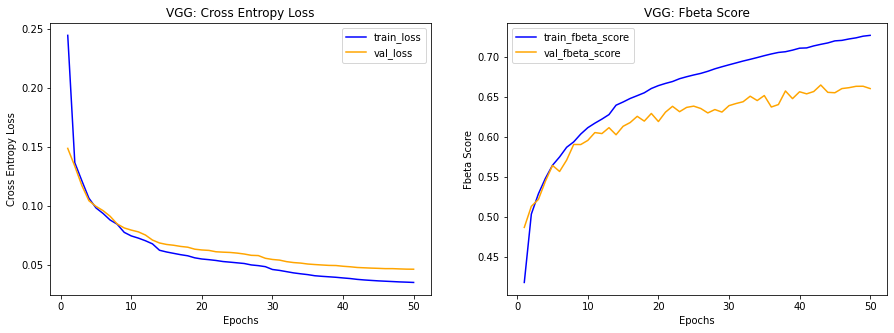

In [0]:
# entry point, run the test harness for vgg model without augmentation
model = define_vgg_model()
run_test_harness(model, 'VGG', epochs=50, featurewise_center = True)

In [0]:
# run the test harness for VGG model with dropout at last layer
model = define_vgg_model(dropout=True)
run_test_harness(model, 'VGG_dropout', 50, featurewise_center = True)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train images Shape:  (30867, 60, 80, 3) Train labels shape: (30867, 205)
Test images shape:  (13229, 60, 80, 3) Test labels shape:  (13229, 205)


Epoch 1/50
242/242 [==============================] - 36s 147ms/step - loss: 0.3604 - fbeta: 0.3673 - val_loss: 0.1889 - val_fbeta: 0.4490
Epoch 2/50
242/242 [==============================] - 28s 115ms/step - loss: 0.1901 - fbeta: 0.4420 - val_loss: 0.1474 - val_fbeta: 0.4799
Epoch 3/50
242/242 [==============================] - 28s 115ms/step - loss: 0.1391 - fbeta: 0.4760 - val_loss: 0.0919 - val_fbeta: 0.4999
Epoch 4/50
242/242 [==============================] - 28s 116ms/step - loss: 0.1000 - fbeta: 0.5002 - val_loss: 0.0728 - val_fbeta: 0.5309
Epoch 5/50
242/242 [==============================] - 28s 117ms/step - loss: 0.08

In [0]:
while not os.path.exists(folder_path + '/VGG_dropout_plot.png'):
    time.sleep(1)
time.sleep(1)
files.download(folder_path+'/VGG_dropout_plot.png')

In [0]:
#run the test harness for VGG model with finetuning
model = define_vgg_model(model_trainable=True, lr=0.001)
run_test_harness(model, 'VGG_fine_tune', 50, featurewise_center = True)

Train images Shape:  (30867, 60, 80, 3) Train labels shape: (30867, 205)
Test images shape:  (13229, 60, 80, 3) Test labels shape:  (13229, 205)
Epoch 1/50
242/242 [==============================] - 34s 139ms/step - loss: 0.7317 - fbeta: 0.2871 - val_loss: 0.6880 - val_fbeta: 0.2897
Epoch 2/50
242/242 [==============================] - 33s 137ms/step - loss: 0.2426 - fbeta: 0.2669 - val_loss: 0.0677 - val_fbeta: 0.2901
Epoch 3/50
242/242 [==============================] - 33s 136ms/step - loss: 0.0666 - fbeta: 0.2984 - val_loss: 0.0663 - val_fbeta: 0.2902
Epoch 4/50
242/242 [==============================] - 33s 136ms/step - loss: 0.0658 - fbeta: 0.2918 - val_loss: 0.0659 - val_fbeta: 0.2902
Epoch 5/50
242/242 [==============================] - 33s 137ms/step - loss: 0.0655 - fbeta: 0.3021 - val_loss: 0.0657 - val_fbeta: 0.2902
Epoch 6/50
242/242 [==============================] - 33s 136ms/step - loss: 0.0654 - fbeta: 0.2937 - val_loss: 0.0656 - val_fbeta: 0.3842
Epoch 7/50
242/242 [=

In [0]:
while not os.path.exists(folder_path + '/VGG_fine_tune_plot.png'):
    time.sleep(1)
time.sleep(1)
files.download(folder_path+'/VGG_fine_tune_plot.png')

In [0]:
#run the test harness for VGG model and dropout with finetuning
model = define_vgg_model(model_trainable=True, dropout=True)
run_test_harness(model, 'VGG_dropout_fine_tune', 50, featurewise_center = True)

In [0]:
while not os.path.exists(folder_path + '/VGG_dropout_fine_tune_plot.png'):
    time.sleep(1)
time.sleep(1)
files.download(folder_path+'/VGG_dropout_fine_tune_plot.png')

In [0]:
# entry point, run the test harness for VGG model with augmentation and finetuning
model = define_vgg_model()
run_test_harness(model, 'VGG_Img_Aug_fine_tune', 50, 0.1, 0.1, 0.1, True, True, 90, featurewise_center = True)

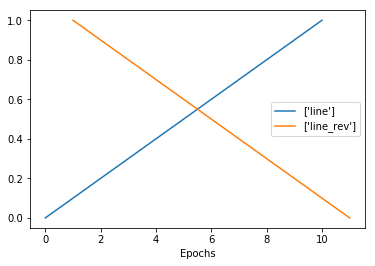

In [0]:
l=np.linspace(0,1,11)
# fig,ax=pyplot.figure(figsize=(6,4))
pyplot.figure()
pyplot.plot(range(11), l, label=['line'])
pyplot.plot(range(11,0,-1), l, label=['line_rev'])
pyplot.xlabel('Epochs')
pyplot.legend()
# pyplot.close()